In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import dask
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import seaborn as sns
import statsmodels.api as sm
import sys
import torch

from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster
from scipy.optimize import root_scalar
from scipy.stats import norm, gamma, beta
from sklearn.gaussian_process import GaussianProcessRegressor

from model.wrapper import Ov
from model.parameters import gamma
from model.ode import OvIntervention as OvODE, calculate_parameters

/scicore/home/chitnis/kamlar00/miniconda3/envs/bo5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set_palette("deep")
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 1.2)
mpl.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams["axes.grid.axis"] ="both"
plt.rcParams["axes.grid"] = True

Adapt dask cluster to your own setup

In [4]:
cluster = SLURMCluster(cores = 1, memory = '4GB', log_directory = 'tmp/slurm-logs/',
                      job_extra_directives = ['--qos="30min"'],
                              job_script_prologue=[
        'ml purge',
        'conda activate bo5',
    ],)
cluster.adapt(minimum_jobs = 1, maximum_jobs=400)
client = Client(cluster)

/scicore/home/chitnis/kamlar00/miniconda3/envs/bo5/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42617 instead
  warnings.warn(


# Loading Data

In [5]:
worm_to_epg = gamma.worm_to_epg
epg_to_worm = gamma.epg_to_worm

In [6]:
epg2012 = pd.read_csv('data/IDRC-2012.csv')[['ovepg']]
epg2018 = pd.read_csv('data/IDRC-2018.csv')[['ovepg']]

In [7]:
def summarize_epg_data(df):
    df = df.copy()
    df.rename({'ovepg': 'epg'}, inplace=True, axis=1)
    df['Worms'] = epg_to_worm(df.epg)
    df['ov'] = df['epg']>0
    df['epg_group'] = 'humans_epg_none'
    df.loc[df['epg']>0, 'epg_group'] = 'humans_epg_low'
    df.loc[df['epg']>999, 'epg_group'] = 'humans_epg_medium'
    df.loc[df['epg']>9999, 'epg_group'] = 'humans_epg_high'
    df_epg_proportions = (df[['epg', 'epg_group']].groupby('epg_group').count()/len(df)).reset_index()
    df_epg_proportions['epg_group'] = df_epg_proportions['epg_group'] + "_prop"
    df_epg_proportions['sem'] = np.sqrt(df_epg_proportions.epg*(1-df_epg_proportions.epg)/len(df))

    df_epg_means = df[['epg', 'epg_group']].groupby('epg_group').agg(['mean', 'sem'])
    df_epg_means = df_epg_means['epg'].rename({'mean': 'epg'}, axis=1).reset_index()
    df_epg_means['epg_group'] = df_epg_means['epg_group'] + '_mean'
    df_epg_ss = pd.concat([df_epg_proportions, df_epg_means]).rename({'epg_group': 'variable', 'epg': 'value'}, axis=1)
    df_worms = pd.DataFrame({'variable': ['prevalence_humans_eligible', 'worms_per_human_eligible'],
                                  'value': [df.ov.mean(), df.Worms.mean()],
                                  'sem': [np.sqrt(df.ov.mean()*(1-df.ov.mean())/len(df)), df.Worms.sem()]
                                },)
    df = pd.concat([df_epg_ss, df_worms])
    return df



data12human = summarize_epg_data(epg2012)
data_animals = pd.read_csv('model/parameters/dogs-cats-buffalos.csv')
data_animals['worms'] = epg_to_worm(data_animals.OVEGG)
data_animals_means = data_animals[['ANIMAL', 'worms']].groupby('ANIMAL').mean()
data_animals_sems = data_animals[['ANIMAL', 'worms']].groupby('ANIMAL').sem()
data12nonhuman = pd.DataFrame({
    'variable': ['prevalence_fish', 'prevalence_snails', 'worms_per_cat', 'worms_per_dog'],
    'value': [0.2715, 0.0029, data_animals_means.loc['cat', 'worms'], data_animals_means.loc['dog', 'worms']],
    'sem': [np.sqrt(0.2715*(1-0.2715)/628), 
            np.sqrt(0.0029*(1-0.0029)/3102), 
            data_animals_sems.loc['cat', 'worms'], 
            data_animals_sems.loc['dog', 'worms']]
})
data12 = pd.concat([data12human, data12nonhuman]).reset_index()

data18 = summarize_epg_data(epg2018)

In [8]:
labels_mapping = {
    'worms_per_human_eligible': 'Worms per human',
    'worms_per_dog': 'Worms per dog',
    'worms_per_cat': 'Worms per cat',
    'prevalence_fish': 'Prevalence fish',
    'prevalence_humans_eligible': 'Prevalence humans',
    'prevalence_snails': 'Prevalence snails',
    'humans_epg_none_prop': 'Prevalence None',
    'humans_epg_low_prop': 'Prevalence light',
    'humans_epg_medium_prop': 'Prevalence moderate',
    'humans_epg_high_prop': 'Prevalence heavy',
    'humans_epg_none_mean': 'Mean none',
    'humans_epg_low_mean': 'Mean light',
    'humans_epg_medium_mean': 'Mean moderate',
    'humans_epg_high_mean': 'Mean heavy',
    'humans_epg_mean': 'Mean EPG',
    'k': 'k'
}
data12['variable_name'] = data12.variable.replace(labels_mapping)
data18['variable_name'] = data18.variable.replace(labels_mapping)

Derive k for 2012 and 2018 data

In [9]:
def f(k, M, P):
    return 1 - (1 + M/k)**(-k) - P
def calculate_k(M, P):
    sol = scipy.optimize.root_scalar(f, args=(M, P), bracket=(0.01,2), method='bisect')
    return sol.root
k12 = calculate_k(data12[data12.variable=='worms_per_human_eligible']['value'].item(), data12[data12.variable=='prevalence_humans_eligible']['value'].item())
k18 = calculate_k(data18[data18.variable=='worms_per_human_eligible']['value'].item(), data18[data18.variable=='prevalence_humans_eligible']['value'].item())
print('k worms 2012:', k12)
print('k worms 2018:', k18)

k worms 2012: 0.1147375303287754
k worms 2018: 0.03341958563988554


## Fig 1: Distribution of EPG among humans

In [10]:
fdata12 = epg2012
fdata12['year'] = 2012
fdata18 = epg2018
fdata18['year'] = 2018
fdata = pd.concat([fdata12,fdata18]).reset_index()

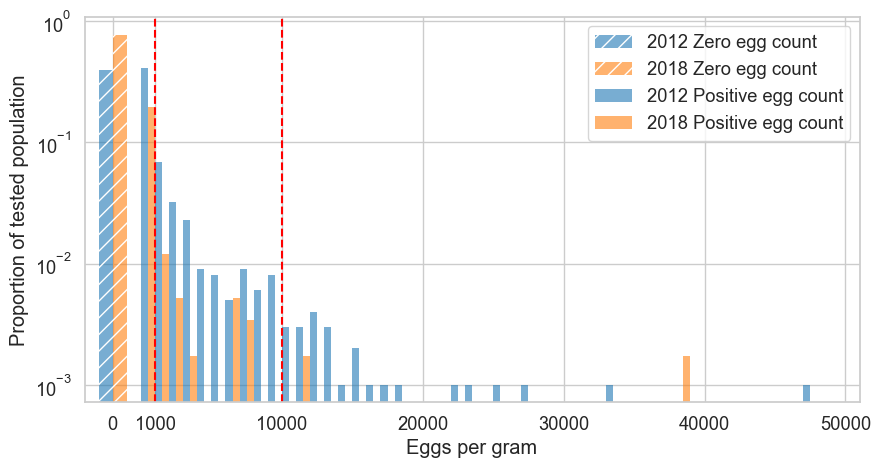

In [12]:
bins = np.concatenate([np.array([0, 1]), np.arange(1000, 50001, 1000)])
sns.histplot(data=fdata, x='ovepg', hue='year', stat='proportion', multiple='dodge', common_norm=False, 
             palette=['tab:blue', 'tab:orange'], alpha=.6, bins=bins)
plt.yscale('log')
plt.axvline(x=1000, c='r', ls='--')
plt.axvline(x=10000, c='r', ls='--')
plt.xlabel('Eggs per gram')
plt.ylabel('Proportion of tested population')
ax = plt.gca()

ax.patches[0].set(width=1000, x=-2000, hatch='//', label='2018 Zero egg count')
ax.patches[len(bins)-1].set(width=1000, x=-3000, hatch='//', label='2012 Zero egg count')

ax.patches[5].set(label='2018 Positive egg count')
ax.patches[len(bins)+5].set(label='2012 Positive egg count')

ax.legend()
ax.set_xlim((-4000, 51000))

ax.set_xticks([-2000, 1000, 10000, 20000, 30000, 40000, 50000],
              labels=[0, 1000, 10000, 20000, 30000, 40000, 50000])

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.savefig(f'plots/epg_data.pdf', bbox_inches="tight")
plt.savefig(f'plots/epg_data.tiff', bbox_inches="tight")

# Modeling 

## Model Setup

### ABM

Choose the model variant:
* no_an: Set to True for models without cats and dcots as definitive hosts

In [13]:
no_an = False
no_an_str = '_no_an' if no_an else ''

In [14]:
if not no_an:
    from model.parameters.gamma import p as parameters_gamma
else:
    from model.parameters.gamma_nocatdog import p as parameters_gamma
ABM_parameters = parameters_gamma

In [15]:
model_colors = {
    'ABM': sns.color_palette()[0],
    'PBM': sns.color_palette()[1],
    }
model_styles = {
    'ABM': '-',
    'PBM': '-',
}
model_labels = {
    'ABM': 'ABM',
    'PBM': 'PBM',
}

In [16]:
def get_ovABM_warmup(parameters):
    ov = Ov(parameters, store_raw=True)
    ov.run()
    return ov

Run warmup period to reach equilibrium . Can also be loaded from checkpoint. Make sure to rerun warmup when switching between animal- and nonanimal model.

In [17]:
global_seeds = np.arange(10)
rerun_warmups = True

if rerun_warmups:
    # Run warmups
    warmups = []
    for seed in global_seeds:
        model_parameter_seed = ABM_parameters.copy()
        model_parameter_seed['seed'] = seed
        model_parameter_seed['number_of_years'] = 100
        model_parameter_seed['timesteps_per_year'] = 120
        warmups.append(dask.delayed(get_ovABM_warmup)(model_parameter_seed))
    warmups = list(dask.compute(*warmups))

    # Store checkpoints
    for i, seed in enumerate(global_seeds):
        checkpointdir = f"checkpoints/{seed}/"
        os.makedirs(checkpointdir, exist_ok=True)
        np.save(f"{checkpointdir}checkpoint_history", warmups[i].history_raw)
        np.save(f"{checkpointdir}/checkpoint_humans", warmups[i].humans_raw)
        pickle.dump(warmups[i], open(f"{checkpointdir}/warmup.pickle", 'wb'))
else:
    warmups = []    
    for seed in global_seeds:
        file = open(f"checkpoints/{seed}/warmup.pickle", 'rb')
        ov = pickle.load(file)
        file.close()
        warmups.append(ov)

Plot one warmup to check things are right

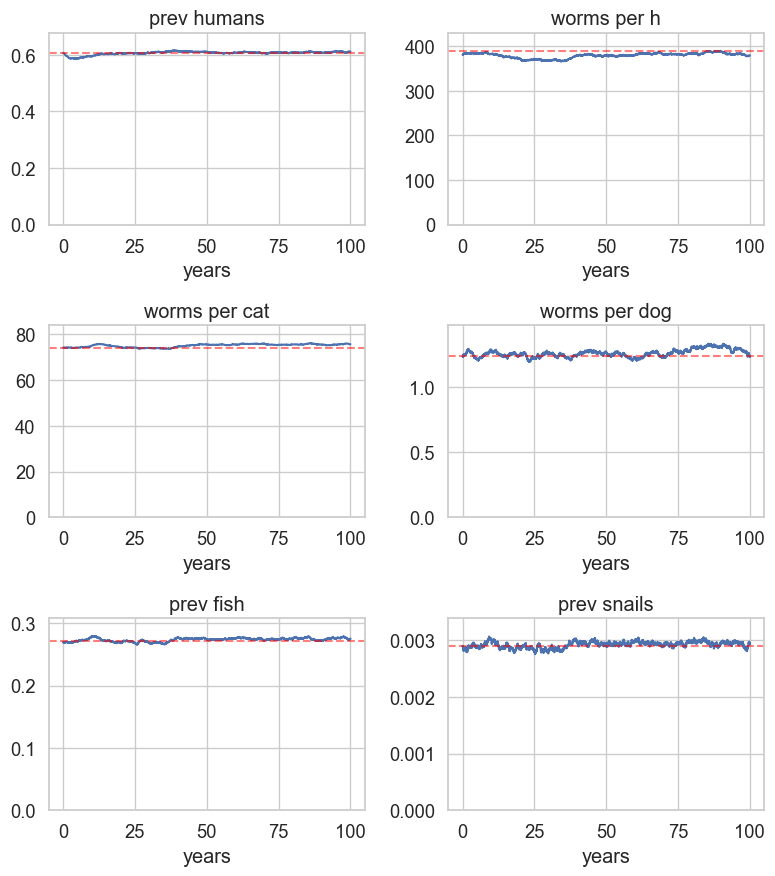

In [17]:
targets = dict(zip(data12['variable'], data12['value']))
warmups[0].plot_separate(hlines=targets)

### PBM

Set parameters and initial values of ODE model such that results are comparable to the ABM model 

In [18]:
target_values = {
    'w_h': data12.loc[data12.variable == 'worms_per_human_eligible', 'value'].item(),
    'w_d': data12.loc[data12.variable == 'worms_per_dog', 'value'].item(),
    'w_c': data12.loc[data12.variable == 'worms_per_cat', 'value'].item(),
    'i_s': data12.loc[data12.variable == 'prevalence_snails', 'value'].item(),
    'i_f': data12.loc[data12.variable == 'prevalence_fish', 'value'].item(),
}
if no_an:
    target_values.update({
        'w_d': 0,
        'w_c': 0,
})
ovABM_warmup = warmups[0]
parameters_ODE = {
    'n_h': ovABM_warmup.parameters['N'],
    'n_d': ovABM_warmup.parameters['N_dogs'],
    'n_c': ovABM_warmup.parameters['N_cats'],
    'n_s': ovABM_warmup.parameters['N_snails'],
    'n_f': ovABM_warmup.parameters['N_fish'],
    'mu_ph': ovABM_warmup.parameters['mu_ph'],
    'mu_pd': ovABM_warmup.parameters['mu_pd'],
    'mu_pc': ovABM_warmup.parameters['mu_pc'],
    'mu_s': ovABM_warmup.parameters['mu_s'],
    'mu_f': ovABM_warmup.parameters['mu_f'],
    'y0': [target_values['w_h'],
            target_values['w_d'],
            target_values['w_c'],
            target_values['i_s'],
            target_values['i_f'],]
}
parameters_ODE.update(calculate_parameters(**parameters_ODE, **target_values))

### Compare parameter values of ABM and PBM

In [19]:
{key: val for (key, val) in warmups[0].parameters.items() if key[:4] == 'log_'}

{'log_beta_hf_mean': -0.3141,
 'log_beta_hf_variance': 0.298,
 'log_beta_df': -2.498,
 'log_beta_cf': -0.726,
 'log_beta_sx': -9.894,
 'log_beta_fs': -0.8518}

In [20]:
{key: val for (key, val) in parameters_ODE.items() if key[:2] == 'b_'}

{'b_hf': 0.3936746440447981,
 'b_df': 0.003116360447153205,
 'b_cf': 0.18698162682919228,
 'b_sh': 1.7118683519719244e-08,
 'b_sd': 1.7118683519719244e-08,
 'b_sc': 1.7118683519719244e-08,
 'b_fs': 0.1408346136725641}

## Figure 4, 5: Equilibrium EPG distribution and interventions without systematic adherence 

### Run simulations

In [21]:
years_warmup2 = 1
years_MDA = 5
MDA_coverages = [0, .8]
years_total = years_warmup2 + years_MDA
MDA_days = (np.arange(years_MDA)+years_warmup2)*365

In [22]:
df_ts_all = pd.DataFrame()
df_worms_all = pd.DataFrame()
df_worm_days_all = pd.DataFrame()

for i, MDA_coverage in enumerate(MDA_coverages):

    # Run ABM
    df_ts_ABM = pd.DataFrame()
    df_worms_ABM = pd.DataFrame()

    for j, seed in enumerate(global_seeds):

        parameters_ABM = warmups[j].parameters.copy()
        parameters_ABM['number_of_years'] = years_total

        parameters_ABM['MDA_strategy'] = "random"
        parameters_ABM['MDA_timing'] = MDA_days
        parameters_ABM['MDA_coverage'] = np.repeat(MDA_coverage, years_MDA)

        parameters_ABM['education_timing'] = np.array([365])
        parameters_ABM['education_coverage'] = np.repeat(1, len(parameters_ABM['education_timing']))
        parameters_ABM['education_efficacy'] = np.repeat(.1, len(parameters_ABM['education_timing']))
        parameters_ABM['education_strategy'] = "random"
        parameters_ABM['educ_decay'] = 1 # corresponds to no decay

        parameters_ABM['latrine_change_timing'] =  np.array([365])
        parameters_ABM['latrine_change_coverage'] = np.array([.9])
        parameters_ABM['latrine_change_strategy'] = 'addition'

        ov_ABM = Ov(parameters_ABM, checkpoint_directory=f"checkpoints/{seed}/")

        history, humans = ov_ABM.run()
        
        # Append time series data
        df_ts_ABM_sim = ov_ABM.history[['prevalence_humans_eligible', 'worms_per_human_eligible', 'worms_per_dog', 'worms_per_cat', 
                    'prevalence_snails', 'prevalence_fish', 'humans_epg_mean', 'humans_epg_low_mean', 'humans_epg_low_prop',
                                           'humans_epg_medium_mean', 'humans_epg_medium_prop', 'humans_epg_high_mean', 'humans_epg_high_prop' ,'k']].reset_index()
        df_ts_ABM_sim['Source'] = 'ABM'
        df_ts_ABM_sim['seed'] = seed

        df_ts_ABM = pd.concat([df_ts_ABM, df_ts_ABM_sim])

        # Append final population distribution data
        idx_eligible = humans.age>ov_ABM.parameters['minimum_age_for_worm_infection']
        df_worms_ABM_sim = pd.DataFrame({'Worms': humans.worms[idx_eligible], 'Source': 'ABM'})
        df_worms_ABM_sim['seed'] = seed
        df_worms_ABM = pd.concat([df_worms_ABM, df_worms_ABM_sim])

        # Append final worm days distribution data
        df_worms_days_sim = pd.DataFrame({'worm_days': humans.worm_days, 'coverage': MDA_coverage, 'seed': seed})
        df_worm_days_all = pd.concat([df_worm_days_all, df_worms_days_sim])

        
    # Run PBM
    config_ODE = {
        'tf': 365 * years_total,
    }
    MDA_campaign_ODE = np.array((1-MDA_coverage, 1, 1, 1, 1))
    population_modifiers = [np.array((1, 1, 1, 1, 1))] + [MDA_campaign_ODE] * years_MDA

    parameters_ODE['schedule'] = pd.DataFrame.from_dict({
        't': np.insert(MDA_days, 0, 0),
        'population': population_modifiers, # MDA campaign
        'parameters': [{}] + [{
            'b_hf': parameters_ODE['b_hf']*.1, # Education campaign
            'b_sh': parameters_ODE['b_sh']*.178 # Increased latrine coverage
        }] * (years_MDA),
    })
    ov_ODE = OvODE(parameters_ODE, config_ODE, timer=False)
    
    # Calculate prevalence and mean EPG based on mean worm burden
    df_ts_ODE = ov_ODE.result    
    df_ts_ODE = df_ts_ODE.drop_duplicates()
    ilocs = np.round(np.linspace(0, len(df_ts_ODE)-1, years_total*12+1))
    df_ts_ODE = df_ts_ODE.iloc[ilocs]
    df_ts_ODE['humans_epg_mean'] = worm_to_epg(df_ts_ODE['worms_per_human'])
    df_ts_ODE['k'] = k12
    df_ts_ODE['Source'] = 'PBM'

    # Derive distributional data from mean worm burden given negative binomial assumption and k estimated from 2012 data
    epg_ss_ODE_all = pd.DataFrame()
    for seed in global_seeds:
        epg_ss_ODE_seed = pd.DataFrame()
        for idx, row in df_ts_ODE.iterrows():
            m_new = row.worms_per_human
            p_new = k12/(k12+m_new)
            rvs = scipy.stats.nbinom.rvs(k12, p_new, size=15000)
            epg_ss = summarize_epg_data(pd.DataFrame({'ovepg': worm_to_epg(rvs)}))
            epg_ss = epg_ss.pivot_table(columns='variable', values='value')
            epg_ss['t'] = row['t']
            epg_ss['seed'] = seed
            epg_ss.index = [idx,]
            epg_ss_ODE_seed = pd.concat([epg_ss_ODE_seed, epg_ss])
            
        epg_ss_ODE_all = pd.concat([epg_ss_ODE_all, epg_ss_ODE_seed])
        # print(f'for seed{seed}')
        # print(epg_ss_ODE_seed)
    
    df_ts_ODE = pd.merge(df_ts_ODE, epg_ss_ODE_all, on='t')
    df_ts_ODE = df_ts_ODE.reset_index(drop=True)

    # Sample worm distribution at end of PBM simulation
    m_new = ov_ODE.result.worms_per_human.iloc[-1]
    p_new = k12/(k12+m_new)
    rvs = scipy.stats.nbinom.rvs(k12, p_new, size=parameters_ABM['N'])
    df_worms_ODE = pd.DataFrame({'Worms': rvs, 'Source': 'PBM', 'seed': 0})

    # Concat time series results of PBM of ABM 
    df_ts = pd.concat([df_ts_ABM, df_ts_ODE])
    df_ts = pd.melt(df_ts, id_vars=['t', 'Source', 'seed'])
    df_ts['coverage'] = MDA_coverage
    df_ts_all = pd.concat([df_ts_all, df_ts])
    
    # Concat final worm distribution of PBM and ABM
    df_worms = pd.concat([df_worms_ODE, df_worms_ABM], axis=0)
    df_worms['coverage'] = MDA_coverage
    df_worms_all = pd.concat([df_worms_all, df_worms])

In [23]:
df_ts_all = df_ts_all.reset_index(drop=True)
df_worms_all = df_worms_all.reset_index(drop=True)
df_worm_days_all = df_worm_days_all.reset_index(drop=True)

Prepare time series dataframe for plotting

In [24]:
df_ts_all = df_ts_all.replace(labels_mapping)

In [25]:
variable_order = {
    'Prevalence humans': 0,
    'Worms per human': 1,
    'Worms per dog': 2,
    'Worms per cat': 3,
    'Prevalence snails': 4,
    'Prevalence fish': 5,
    'Prevalence light': 6,
    'Mean light': 9,
    'Prevalence moderate': 7,
    'Mean moderate': 10,
    'Prevalence heavy': 8,
    'Mean heavy': 11,
    'k': 12,
}
variable_percentage = {
    'Prevalence humans': True,
    'Worms per human': False,
    'Worms per dog': False,
    'Worms per cat': False,
    'Prevalence snails': True,
    'Prevalence fish': True,
    'Prevalence light': True,
    'Mean light': False,
    'Prevalence moderate': True,
    'Mean moderate': False,
    'Prevalence heavy': True,
    'Mean heavy': False,
    'k': False,
}

In [26]:
df_ts_all = df_ts_all.loc[df_ts_all.variable.isin(variable_order.keys())].copy()
df_ts_all['variable_order'] = df_ts_all['variable'].map(variable_order)
df_ts_all = df_ts_all.sort_values(['variable_order', 'Source'])
df_ts_all['t'] = df_ts_all['t'] + 2012

### Figure 4: Example run under MDA, education and latrine improvement (no systematic adherence)

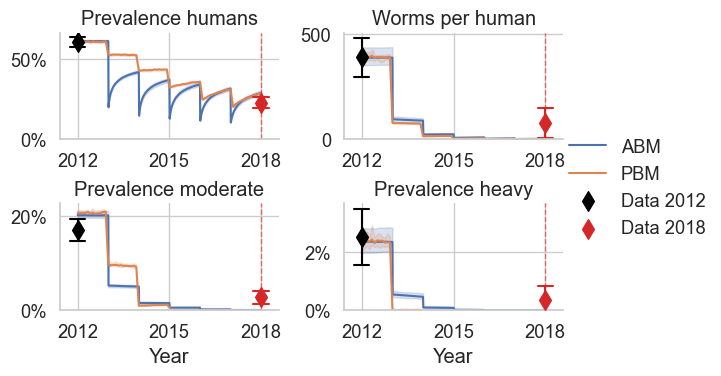

In [27]:
df_ts_coverage = df_ts_all[(df_ts_all['coverage']==.8) & (df_ts_all['variable']!='humans_epg_mean')]

vars_choice = ['Prevalence humans', 'Worms per human' , 'Prevalence moderate', 'Prevalence heavy']

g = sns.FacetGrid(df_ts_coverage[df_ts_coverage.variable.isin(vars_choice)], col='variable', col_wrap=2, 
                  sharex=False, sharey=False, height=2, aspect=1.5)
ci_line_width = .5

for ax, var in zip(g.axes, vars_choice):
    df_plot = df_ts_coverage[df_ts_coverage.variable == var]
    df_plot = df_plot.sort_values('Source') 
    
    for i, source in enumerate(df_plot.Source.unique()):
        df_line = df_plot[df_plot.Source==source]
        df_line = df_line.sort_values(['t'])
        sns.lineplot(data=df_line, x='t', y='value', errorbar=("pi", 100), ls=model_styles[source], ax=ax, label=model_labels[source])
    if variable_percentage[var]:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    try:        
        # Plot CI at start
        mu = data12.loc[data12['variable_name']==var, 'value'].item()
        sigma = data12.loc[data12['variable_name']==var, 'sem'].item()
        
        left = 2012 + ci_line_width/2
        right = 2012 - ci_line_width/2
        lower = mu - 1.96*sigma
        upper = mu + 1.96*sigma
        
        ax.plot([left, right], [upper]*2, c='k')
        ax.plot([left, right], [lower]*2, c='k')
        ax.scatter(2012, mu, c='k', zorder=10, marker='d', s=100, label='Data 2012')
        ax.plot([2012, 2012], [lower, upper], c='k')
        
        # Plot CI at end
        mu = data18.loc[data18['variable_name']==var, 'value'].item()
        sigma = data18.loc[data18['variable_name']==var, 'sem'].item()
        left = 2012 + years_total + ci_line_width/2
        right = 2012 + years_total - ci_line_width/2
        lower = mu - 1.96*sigma
        upper = mu + 1.96*sigma
        
        ax.plot([left, right], [upper]*2, c='tab:red')
        ax.plot([left, right], [lower]*2, c='tab:red')
        ax.scatter(2012 + years_total, mu, c='tab:red', zorder=10, marker='d', s=100, label='Data 2018')
        ax.plot([2012 + years_total, 2012 + years_total], [lower, upper], c='tab:red')
    except:
        pass

g.map(plt.axvline, x=2012 + years_warmup2 + years_MDA, color='r', linestyle='--', linewidth=1, alpha=.5)
g.set(ylim=(0, None), xticks=[2012, 2015, 2018])
g.set_titles('{col_name}')
g.set_axis_labels('Year', '')
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.3)
g.add_legend()

plt.savefig(f'plots/model_runs{no_an_str}.tiff', bbox_inches="tight")
plt.savefig(f'plots/model_runs{no_an_str}.pdf', bbox_inches="tight")

### Figure 4: All variables (supplementary information)

Set choice to 'distr' or 'means' for Figure 5 subplots

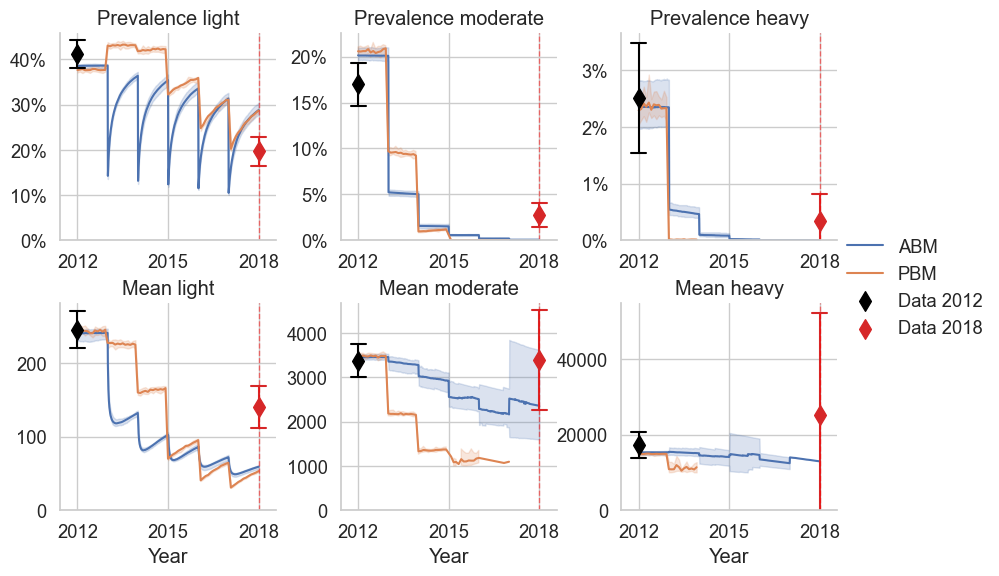

In [28]:
# choice = 'means'
choice = 'distr'

coverage_single = .8

df_ts_coverage = df_ts_all[(df_ts_all['coverage']==coverage_single) & (df_ts_all['variable']!='humans_epg_mean')]
if choice == 'means':
    vars_choice = ['Prevalence humans', 'Worms per human', 'Worms per dog',
           'Worms per cat', 'Prevalence snails', 'Prevalence fish',]
else:
    vars_choice = ['Prevalence light', 'Prevalence moderate', 'Prevalence heavy',
           'Mean light', 'Mean moderate', 'Mean heavy']

g = sns.FacetGrid(df_ts_coverage[df_ts_coverage.variable.isin(vars_choice)], col='variable', col_wrap=3, sharex=False, sharey=False, height=3)
ci_line_width = .5

for ax, var in zip(g.axes, vars_choice):
    df_plot = df_ts_coverage[df_ts_coverage.variable == var]
    df_plot = df_plot.sort_values('Source') 
    for i, source in enumerate(df_plot.Source.unique()):
        df_line = df_plot[df_plot.Source==source]
        df_line = df_line.sort_values(['t'])
        sns.lineplot(data=df_line, x='t', y='value', errorbar=("pi", 100), ls=model_styles[source], ax=ax, label=model_labels[source])
    if variable_percentage[var]:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    try:        
        # Plot CI at start
        mu = data12.loc[data12['variable_name']==var, 'value'].item()
        sigma = data12.loc[data12['variable_name']==var, 'sem'].item()
        
        left = 2012 + ci_line_width/2
        right = 2012 - ci_line_width/2
        lower = mu - 1.96*sigma
        upper = mu + 1.96*sigma
        
        ax.plot([left, right], [upper]*2, c='k')
        ax.plot([left, right], [lower]*2, c='k')
        ax.scatter(2012, mu, c='k', zorder=10, marker='d', s=100, label='Data 2012')
        ax.plot([2012, 2012], [lower, upper], c='k')
        
        # Plot CI at end
        mu = data18.loc[data18['variable_name']==var, 'value'].item()
        sigma = data18.loc[data18['variable_name']==var, 'sem'].item()
        left = 2012+years_total + ci_line_width/2
        right = 2012+years_total - ci_line_width/2
        lower = mu - 1.96*sigma
        upper = mu + 1.96*sigma
        
        ax.plot([left, right], [upper]*2, c='tab:red')
        ax.plot([left, right], [lower]*2, c='tab:red')
        ax.scatter(2012+years_total, mu, c='tab:red', zorder=10, marker='d', s=100, label='Data 2018')
        ax.plot([2012+years_total, 2012+years_total], [lower, upper], c='tab:red')
    except:
        pass

g.map(plt.axvline, x=2012+years_warmup2+years_MDA, color='r', linestyle='--', linewidth=1, alpha=.5)
g.set(ylim=(0, None), xticks=[2012, 2015, 2018])
g.set_titles('{col_name}')
g.set_axis_labels('Year', '')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
g.add_legend()

plt.savefig(f'plots/model_runs_{choice}_full{no_an_str}.tiff', bbox_inches="tight")
plt.savefig(f'plots/model_runs_{choice}_full{no_an_str}.pdf', bbox_inches="tight")

### Figure 5: Kernel density estimates of EPG in equilibrium

In [29]:
df_epg_model = df_worms_all[(df_worms_all.coverage==0) & (df_worms_all.seed==0)].copy().sort_values('Source')
df_epg_model['ovepg'] = worm_to_epg(df_epg_model.Worms)
fdata12['Source'] = "Data"
df_data_model = pd.concat([df_epg_model, fdata12])

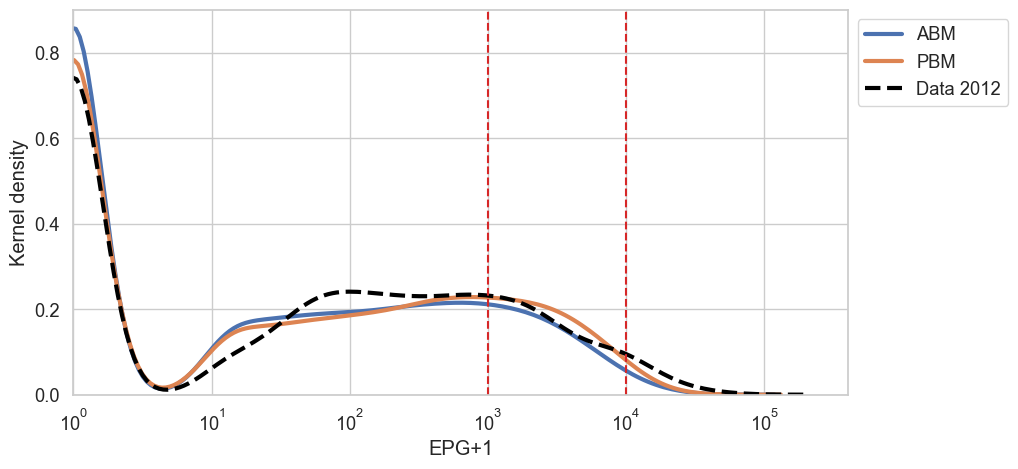

In [30]:
df_data_model_epg = df_data_model.copy()
df_data_model_epg['EPG'] = df_data_model_epg['ovepg'] + 1

bw_method = .15
fig, ax = plt.subplots()
for source in list(df_epg_model.Source.unique()):
    sns.kdeplot(data=df_data_model_epg[df_data_model_epg.Source==source], x='EPG', log_scale=True, common_norm=False, 
                bw_method=bw_method, ax=ax, label=model_labels[source], bw_adjust=1, lw=3,
               color=model_colors[source])
sns.kdeplot(data=df_data_model_epg[df_data_model_epg.Source=='Data'], x='EPG', log_scale=True, common_norm=False, 
            bw_method=bw_method, ax=ax, label='Data 2012', c='k', ls='--', lw=3) 
# ax.legend(labels='wth')
ax.legend()
plt.xlim((1, None))
plt.axvline(x=1000, c='tab:red', ls='--')
plt.axvline(x=10000, c='tab:red', ls='--')
plt.xlabel('EPG+1')
plt.ylabel('Kernel density')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
plt.savefig(f'plots/epg_distriubtion_equilibrium{no_an_str}.tiff', bbox_inches="tight")
plt.savefig(f'plots/epg_distriubtion_equilibrium{no_an_str}.pdf', bbox_inches="tight")

## Figures 6, 7: Interventions under systematic adherence

### Fitting of systematic adherence

Function to run simulations with heterogeneity in MDA campaign and edcuation campaign in dask

In [31]:
def run_ov_get_df(parameters_ABM, seed, treatment_days, MDA_coverage_level, MDA_variance, 
                  education_efficacy, return_last=True, latrine_change_coverage=.9, education_strategy='random', 
                  education_betahf_corr=-1, MDA_strategy='random_individual', MDA_betahf_corr=-1,
                 source='', fake_MDA=False, education_variance=0, return_model=False):
    
    parameters_ABM['seed'] = seed

    # Configure MDA
    parameters_ABM['MDA_timing'] = treatment_days
    parameters_ABM['MDA_strategy'] = MDA_strategy
    if MDA_strategy == 'random':
        parameters_ABM['MDA_coverage'] = np.repeat(MDA_coverage_level, len(treatment_days.squeeze()))
    elif MDA_strategy == 'gaussian_copula':
        parameters_ABM['MDA_coverage'] = MDA_coverage_level
        parameters_ABM['MDA_variance'] = MDA_variance
        parameters_ABM['MDA_copula_correlation'] = MDA_betahf_corr

    # Configure education
    if education_strategy == 'gaussian_copula' and education_efficacy<1:
        parameters_ABM['education_timing'] = treatment_days
        parameters_ABM['education_efficacy'] = education_efficacy
        parameters_ABM['education_strategy'] = education_strategy
        parameters_ABM['education_efficacy_mean'] = education_efficacy
        parameters_ABM['education_efficacy_variance'] = education_variance
        parameters_ABM['education_copula_correlation'] = education_betahf_corr

    # Confige increase in latrine coverage
    parameters_ABM['latrine_change_timing'] =  np.array([365])
    parameters_ABM['latrine_change_coverage'] = np.array([latrine_change_coverage])
    parameters_ABM['latrine_change_strategy'] = 'addition'

    ov_ABM = Ov(parameters_ABM, checkpoint_directory=f"checkpoints/{seed}/", store_raw=True)
    ov_ABM.run()
    
    df_result = ov_ABM.history[[
        'prevalence_humans_eligible', 'worms_per_human_eligible', 'worms_per_dog', 'worms_per_cat', 
        'prevalence_snails', 'prevalence_fish', 'humans_epg_mean', 'humans_epg_low_mean', 'humans_epg_low_prop', 'humans_epg_medium_mean', 
        'humans_epg_medium_prop', 'humans_epg_high_mean', 'humans_epg_high_prop', 'k']].reset_index()
    
    if return_model:
        return ov_ABM

    if return_last:
        df_result = df_result.iloc[[-1]]
    df_result = df_result.assign(
        Source = source,
        seed = seed,
        MDA_coverage = MDA_coverage_level,
        MDA_variance = MDA_variance,
        education_efficacy = education_efficacy,
        education_variance = education_variance,
        MDA_betahf_corr = MDA_betahf_corr,
    )
    return df_result

In [32]:
# For testing above function
# parameters_ABM = warmups[0].parameters.copy()
# parameters_ABM['education_minimum_age'] = 6 * 365

# parameters_ABM['number_of_years'] = 6
# treatment_days = np.expand_dims(((np.arange(5)+1)*365), 0)
# modl = run_ov_get_df(
#     parameters_ABM=parameters_ABM,
#     seed=seed,
#     treatment_days=treatment_days,
#     MDA_coverage_level=.8,
#     MDA_variance=.03,
#     MDA_strategy='gaussian_copula',
#     MDA_betahf_corr=-1,
#     education_strategy='gaussian_copula',
#     education_efficacy=.3,
#     education_variance=.1,
#     education_betahf_corr=1,
#     return_last=False,
#     return_model=True
# )
# modl.plot_separate()
# modl.plot_humans_epg()

Find combinations of means and variances for beta distribution which are defined. This is the space that will be searched over.

In [33]:
def getAlphaBeta(mu, var):
    sigma = np.sqrt(var)
    alpha = mu**2 * ((1 - mu) / sigma**2 - 1 / mu)
    beta = alpha * (1 / mu - 1)
    return alpha, beta

mns = np.linspace(.1, .5, 21)
vars = np.linspace(.0, .3, 21)
combos = []
res= np.empty((len(mns),len(vars)), dtype=bool)
for i in range(len(mns)):
    for j in range(len(vars)):
        works = False
        a, b = getAlphaBeta(mns[i], vars[j])
        nonneg = (a>0) and (b>0)
        if nonneg:
            probs = scipy.stats.beta.rvs(a, b, size=int(10000))
            if np.isnan(probs).sum() == 0:
                works = True
                combos.append((mns[i], vars[j]))
        res[i, j] = works
combos_df = pd.DataFrame(combos, columns=['education_efficacy', 'education_variance'])  
MDA_variances = np.array([.02, 0.03, .04, .06, .08, .1, .12, .14, .155])
MDA_variances_df = pd.DataFrame({'MDA_variance': MDA_variances})
combos_df = combos_df.merge(MDA_variances_df, how='cross')
combos_df.shape

/scratch/kamlar00/slurm-job.30379680/ipykernel_283324/112658587.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = mu**2 * ((1 - mu) / sigma**2 - 1 / mu)


(2349, 3)

Run the simulations

In [34]:
years_warmup2 = 1
years_treatment = 5
MDA_coverages = [ .8]
years_total = years_warmup2 + years_treatment
treatment_days = np.expand_dims(((np.arange(years_treatment)+years_warmup2)*365), 0)
education_days = years_warmup2
MDA_corr = -.9
seeds_ABM = list(range(1))
simulations = []
for idx, row in combos_df.iterrows():
    
    df_ts_ABM = pd.DataFrame()
    df_worms_ABM = pd.DataFrame()
        
    parameters_ABM = warmups[0].parameters.copy()
    parameters_ABM['number_of_years'] = years_total
                
    for seed in seeds_ABM:
        parameters_run = copy.deepcopy(parameters_ABM)
                    
        delayed = dask.delayed(run_ov_get_df)(
            parameters_ABM=parameters_run,
            seed=seed,
            treatment_days=treatment_days,
                
            MDA_strategy='gaussian_copula',    
            MDA_coverage_level=.8,
            MDA_variance=row['MDA_variance'],
            MDA_betahf_corr=MDA_corr,

            education_strategy='gaussian_copula',
            education_efficacy=row['education_efficacy'],
            education_variance=row['education_variance'],
            education_betahf_corr=-MDA_corr,
                
            source='ABM',
            return_last=True,
        )
        simulations.append(delayed)
print(len(simulations))
simulations_computed = dask.compute(*simulations)

2349


Find education campaign efficacy and MDA variance which meet  target prevalence and mean worm burden

In [35]:
ss_to_optimize = ['worms_per_human_eligible', 'prevalence_humans_eligible', 'humans_epg_high_prop', 'humans_epg_medium_prop']
df_final = pd.concat(simulations_computed)[['Source', 'seed', 'MDA_coverage', 'MDA_variance', 'education_efficacy', 'education_variance', 'MDA_betahf_corr'] + ss_to_optimize]
df_final_long = df_final.melt(id_vars=['Source', 'seed', 'MDA_coverage', 'MDA_variance', 'education_efficacy', 'education_variance', 'MDA_betahf_corr'])
df_final_long = pd.merge(df_final_long, data18[['variable', 'value']], on=['variable'], suffixes=('', '_target'))
df_final_long['diff'] = df_final_long.value - df_final_long.value_target
df_final_long['diff_rel'] = (df_final_long.value - df_final_long.value_target)/ df_final_long.value_target
df_final_long['diff_rel_sq'] = df_final_long['diff_rel'] ** 2

In [36]:
df_final = df_final_long.pivot(index=['Source', 'seed', 'MDA_variance', 'education_efficacy', 'education_variance', 'MDA_betahf_corr'],
                   columns='variable', values='diff_rel_sq').reset_index()
df_final['diff_rel_sq_sum'] = df_final[ss_to_optimize].sum(axis=1)
idxmin = df_final['diff_rel_sq_sum'].idxmin()
rowmin = df_final.iloc[idxmin]

In [37]:
# Test: Run model with best fit among the simulated parameter sets
# modl = run_ov_get_df(
#     parameters_ABM=parameters_ABM,
#     seed=seed,
#     treatment_days=treatment_days,
#     MDA_coverage_level=.8,
#     MDA_variance=rowmin['MDA_variance'],
#     education_strategy='gaussian_copula',
#     education_efficacy=rowmin['education_efficacy'],
#     education_variance=rowmin['education_variance'],
#     return_last=False,
#     return_model=True,
#     MDA_strategy='gaussian_copula',
#     MDA_betahf_corr=rowmin['MDA_betahf_corr'],
#     education_betahf_corr=-rowmin['MDA_betahf_corr'],
# )
# print(rowmin)
# modl.plot_separate()
# modl.plot_humans_epg()

In [38]:
import torch

from botorch.models import KroneckerMultiTaskGP, SingleTaskGP
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.models.transforms.outcome import Standardize, Log
from botorch.optim.fit import fit_gpytorch_torch
from gpytorch.mlls import ExactMarginalLogLikelihood

In [39]:
X_names = ['education_efficacy', 'education_variance', 'MDA_variance']

In [40]:
print(f"Fitting GP with MDA-beta correlation {MDA_corr}")
# Select data to fit
df_fit = df_final[df_final.MDA_betahf_corr==MDA_corr]

# Normalize X and transform to tensor
bounds_lower = df_fit[X_names].min().to_numpy()
bounds_upper = df_fit[X_names].max().to_numpy()
bounds_torch = torch.tensor([bounds_lower, bounds_upper])
    
mtgp_train_x = torch.tensor(df_fit[X_names].to_numpy())
mtgp_train_x = normalize(mtgp_train_x, bounds_torch)

# Standardize Y and transform to tensor, store mean and variance to convert back
mtgp_train_y = torch.tensor(df_fit[ss_to_optimize].to_numpy())
mtgp_train_y_mn = mtgp_train_y.mean(dim=0)
mtgp_train_y_std = mtgp_train_y.std(dim=0)
mtgp_train_y = (mtgp_train_y - mtgp_train_y_mn) /  mtgp_train_y_std



# Fit the MTGP
torch.manual_seed(0)
mtgp = KroneckerMultiTaskGP(
            mtgp_train_x,
            mtgp_train_y,
)
mtgp_mll = ExactMarginalLogLikelihood(mtgp.likelihood, mtgp)
fit_gpytorch_torch(mtgp_mll, options={'disp': False, 'lr':.025})


# Small check of prediction at best simulation
idxmin = df_fit['diff_rel_sq_sum'].idxmin()
rowmin = df_fit.loc[idxmin,:]

y_pred = mtgp.posterior(
normalize(
    torch.tensor([rowmin[X_names]]),
    bounds_torch
)).mean
print(y_pred * mtgp_train_y_std + mtgp_train_y_mn)
print(rowmin[ss_to_optimize])

Fitting GP with MDA-beta correlation -0.9


/scratch/kamlar00/slurm-job.30379680/ipykernel_283324/1030550602.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660136134696/work/torch/csrc/utils/tensor_new.cpp:201.)
  bounds_torch = torch.tensor([bounds_lower, bounds_upper])


tensor([[0.0262, 0.0333, 0.1739, 0.0156]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
variable
worms_per_human_eligible      0.023433
prevalence_humans_eligible    0.034308
humans_epg_high_prop          0.021903
humans_epg_medium_prop        0.003894
Name: 620, dtype: object


Visual inspection of GP goodness of fit

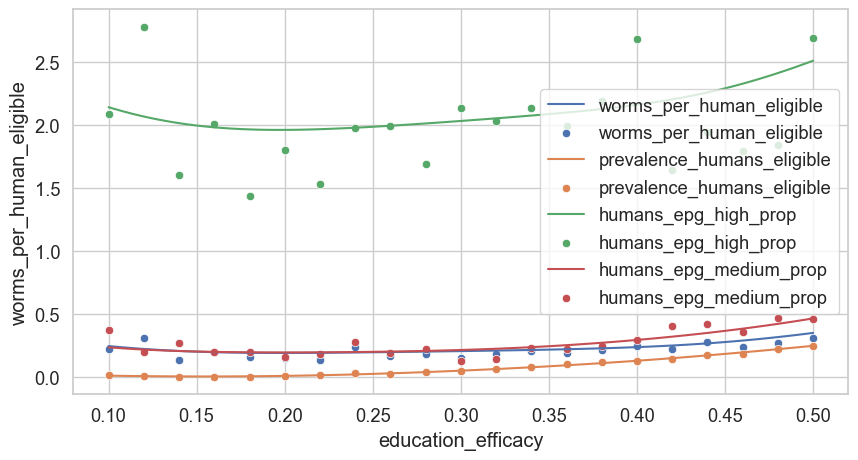

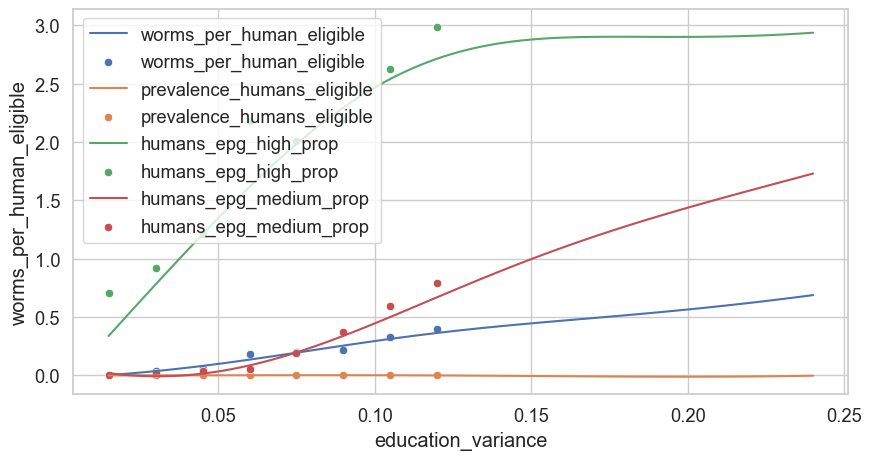

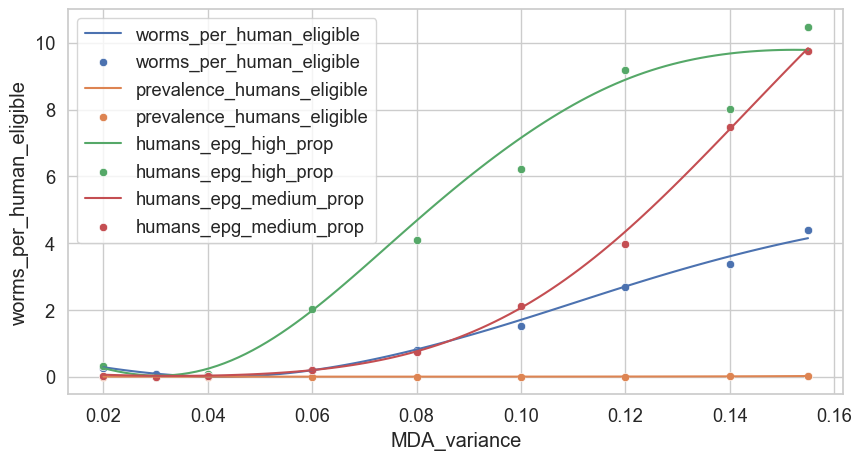

In [41]:
# Pick a random set of values of X
rand_idx = np.random.randint(len(df_fit))
X_random = df_fit[X_names].iloc[rand_idx]
X_random_df = df_fit[X_names].iloc[rand_idx]
X_random_values = [
    X_random[X_name] for X_name in X_names
]

# Loop through the X variables: Keep the other X fixed at randomly drawn values while varying current X  over its range
for i, X_name in enumerate(X_names):
    idx_others = list(range(i)) + list(range(i+1, len(X_names)))
    X_names_others = X_names[:i] + X_names[i+1:]
        
    range_low = bounds_lower[i]
    range_high = bounds_upper[i]
    
    queries = [f'{X_names[j]} == {X_random_values[j]}' for j in idx_others]
    query = ' & '.join(queries)
    df_plot = df_fit.query(query)
    
    # Create a data frame over 
    X_range = np.linspace(range_low, range_high, 100)
    X_pred = df_plot.iloc[[0]][X_names_others]
    X_pred = X_pred.merge(pd.DataFrame({X_name: X_range}), how='cross')
    
    X_pred = X_pred[X_names] # Make sure it's sorted right
    y_pred = mtgp.posterior(
    normalize(
        torch.tensor(X_pred.to_numpy()),
        bounds_torch
    )).mean * mtgp_train_y_std + mtgp_train_y_mn
        
    for j, ss in enumerate(ss_to_optimize):
    
        plt.plot(X_range, y_pred.detach().numpy()[:,j], label=ss)
            
        sns.scatterplot(df_plot, x=X_name, y=ss, label=ss)
        plt.legend()
    plt.show()

Optimiztion: Find X with lowest sum squared error predicted by MTGP =====

In [42]:
# Constraint function used by scipy.optimize.minimize to make sure it stays in parameter space that is for beta distribution
def constraint(X):
    education_efficacy, education_variance, MDA_variance = X
    
    a, b = getAlphaBeta(education_efficacy, education_variance)
    nonneg = (a>0) and (b>0)
    if nonneg:
        probs = scipy.stats.beta.rvs(a, b, size=int(10))
        if np.isnan(probs).sum() >0:
            return -1
    else:
        return -1

    a, b = getAlphaBeta(.8, MDA_variance)
    nonneg = (a>0) and (b>0)
    if nonneg:
        probs = scipy.stats.beta.rvs(a, b, size=int(10))
        if np.isnan(probs).sum() >0:
            return -1
    else:
        return -1
    return 0

# Define function to be used by minimization function with MTGP
def optimand(X):
    X_pred = torch.tensor(np.array([X]))
    y_pred = mtgp.posterior(
        normalize(
            X_pred,
            bounds_torch
        )).mean * mtgp_train_y_std + mtgp_train_y_mn
    return y_pred.detach().numpy().sum()

# Run scipy optimizer
bounds_scipy = [(low, high) for low, high in zip(bounds_lower, bounds_upper)]
np.random.seed(0)
res = scipy.optimize.minimize(optimand, (.3, .1, .04), bounds=bounds_scipy, constraints = {'type': 'ineq', 'fun': constraint})

In [43]:
if not res['success']:
    print('Warning: optimization failed, using best simulation instead')
    opt_values = np.expand_dims(np.array(opt_values), axis=0)
else:
    opt_values = np.expand_dims(res['x'], axis=0)

df_opt = pd.DataFrame(
    opt_values,
    columns = X_names,
)
df_opt['MDA_betahf_corr'] = MDA_corr

In [44]:
df_opt

,education_efficacy,education_variance,MDA_variance,MDA_betahf_corr
0,0.190375,0.084356,0.03205,-0.9


#### Run model once with fitted intervention properties to inspect target summsary statistics

In [45]:
row = df_opt.iloc[0] # Artifact from loop. 
modl = run_ov_get_df(parameters_ABM=parameters_ABM,
              seed=seed,
              treatment_days=treatment_days,
              MDA_coverage_level=.8,
              MDA_variance=row['MDA_variance'],
              education_strategy='gaussian_copula',
              education_efficacy=row['education_efficacy'],
              education_variance=row['education_variance'],
              return_last=False,
            return_model=True,
            MDA_strategy='gaussian_copula',
            MDA_betahf_corr=row['MDA_betahf_corr'],
            education_betahf_corr=-row['MDA_betahf_corr']
)

In [46]:
modl.history.iloc[-1][ss_to_optimize]

worms_per_human_eligible      55.612604
prevalence_humans_eligible     0.239694
humans_epg_high_prop           0.003203
humans_epg_medium_prop         0.029387
Name: 6.0, dtype: float64

In [47]:
data18[data18.variable.isin(ss_to_optimize)]

,variable,value,sem,variable_name
0,humans_epg_high_prop,0.003448,0.002434,Prevalence heavy
2,humans_epg_medium_prop,0.027586,0.006801,Prevalence moderate
0,prevalence_humans_eligible,0.227586,0.017409,Prevalence humans
1,worms_per_human_eligible,75.792388,36.166069,Worms per human


#### Simulate ods ratio of adherence given previous adherence using fitted MDA variance

In [48]:
a, b = getAlphaBeta(.8, df_opt['MDA_variance'])
probs = scipy.stats.beta.rvs(a, b, size=2000000)
probs_rep = np.repeat(np.expand_dims(probs, axis=1), 2, axis=1)
mat = np.random.binomial(1, probs_rep)
df = pd.DataFrame(mat, columns = ['T1', 'T2'])
ct = sm.stats.Table2x2(pd.crosstab(df.T1, df.T2))
print(ct)
ct.oddsratio

A 2x2 contingency table with counts:
[[ 144373.  255535.]
 [ 255979. 1344113.]]


2.966654915123516

Prob being treated given treatment in previous round

In [49]:
dfT1 = df[df.T1==1]
(dfT1.T2==1).sum()/len(dfT1)

0.8400223237163863

Prob being treated given no treatment in previous round

In [50]:
dfT1 = df[df.T1==0]
(dfT1.T2==1).sum()/len(dfT1)

0.6389844664272782

### Sensitivity analysis

In [51]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

In [52]:
problem = {
    'num_vars': len(X_names),
    'names': X_names,
    'bounds': bounds_scipy
}

In [53]:
param_values = saltelli.sample(problem, 1024)

/scratch/kamlar00/slurm-job.30379680/ipykernel_283324/1862108280.py:1: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [54]:
X_pred = torch.Tensor(param_values)
y_pred = mtgp.posterior(
         normalize(
                X_pred,
                bounds_torch
            )).mean * mtgp_train_y_std + mtgp_train_y_mn
y_pred = y_pred.detach().numpy()

In [55]:
Sis = []
S1 = np.zeros((len(ss_to_optimize), len(X_names)))
for i, ss in enumerate(ss_to_optimize):
    print(ss)
    Si = sobol.analyze(problem, y_pred[:,i])
    S1[i, :] = Si['S1']
    Sis.append(Si)

worms_per_human_eligible
prevalence_humans_eligible
humans_epg_high_prop
humans_epg_medium_prop


In [56]:
hm = pd.DataFrame(S1, index=ss_to_optimize, columns=X_names)

In [57]:
hm = hm.rename(
    columns={
        'education_efficacy': '$\mu_e$',
        'education_variance': '$\sigma_e^2$',
        'MDA_variance': '$\sigma_m^2$',
    },
    index=labels_mapping
)

In [58]:
hm

,$\mu_e$,$\sigma_e^2$,$\sigma_m^2$
Worms per human,0.002088,0.078697,0.871792
Prevalence humans,0.742382,0.132867,0.007954
Prevalence heavy,0.001749,0.122997,0.816509
Prevalence moderate,0.001525,0.035495,0.955649


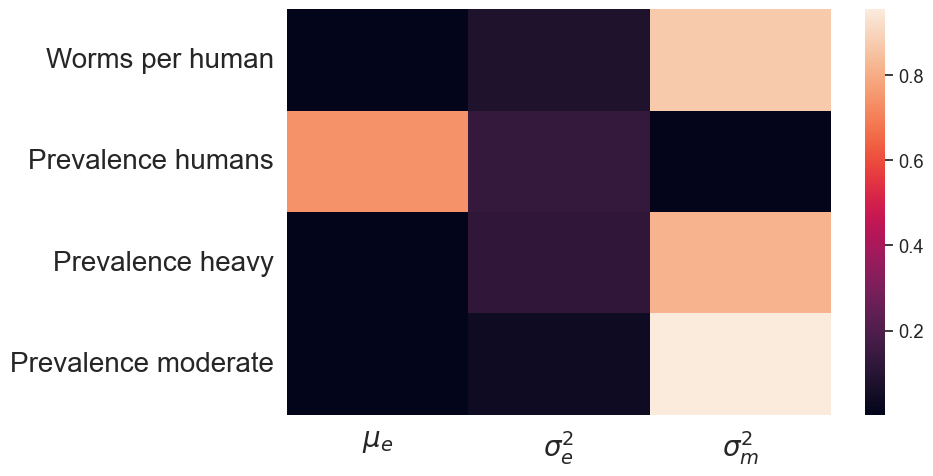

In [59]:
sns.heatmap(hm)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig(f'plots/sensitivity_analysis{no_an_str}.pdf')
plt.savefig(f'plots/sensitivity_analysis{no_an_str}.tiff')

### Run simulations with fitted intervention parameters

Create dataframe containing configurations for baseline and adapted model runs

In [60]:
triple = df_opt.copy()
triple['latrine_change_coverage'] = .9
triple['Source'] = 'Triple interventions systematic'
triple['MDA_coverage_level'] = .8
triple['systematic_adherence'] = True

triple_NSA = triple.copy()
triple_NSA['MDA_variance'] = 1e-5
triple_NSA['education_variance'] = 1e-5
triple_NSA['latrine_change_coverage'] = .9
triple_NSA['Source'] = "Triple interventions nonsystematic"
triple_NSA['systematic_adherence'] = False

latrines_only = triple.copy()
latrines_only['education_efficacy'] = 1
latrines_only['education_variance'] = 1e-5
latrines_only['MDA_coverage_level'] = 0
latrines_only['MDA_variance'] = 1e-5
latrines_only['Source'] =  'Latrines only nonsystematic'
latrines_only['systematic_adherence'] = False

MDA_only = triple.copy()
MDA_only['education_efficacy'] = 1
MDA_only['education_variance'] = 1e-5
MDA_only['latrine_change_coverage'] = .0
MDA_only['Source'] =  'MDA only systematic'
MDA_only['systematic_adherence'] = True

MDA_only_NSA = MDA_only.copy()
MDA_only_NSA['MDA_variance'] = 1e-5
MDA_only_NSA['Source'] =  'MDA only nonsystematic'
MDA_only_NSA['systematic_adherence'] = False

educ_only = triple.copy()
educ_only['latrine_change_coverage'] = .0
educ_only['MDA_coverage_level'] = 0
educ_only['MDA_variance'] = 1e-5
educ_only['Source'] =  'Education only systematic'
educ_only['systematic_adherence'] = True

educ_only_NSA = educ_only.copy()
educ_only_NSA['education_variance'] = 1e-5
educ_only_NSA['Source'] =  'Education only nonsystematic'
educ_only_NSA['systematic_adherence'] = False

df_sims = pd.concat([triple, triple_NSA, latrines_only, MDA_only, MDA_only_NSA, educ_only, educ_only_NSA])

Run the models described in the df_sims dataframe

In [61]:
years_warmup2 = 1
years_treatment = 80
years_total = years_warmup2 + years_treatment
treatment_days = np.expand_dims(((np.arange(years_treatment)+years_warmup2)*365), 0)

In [62]:
simulations = []

for index, row in df_sims.iterrows():
    for k, seed in enumerate(global_seeds):
        parameters_ABM = copy.deepcopy(warmups[k].parameters)
        parameters_ABM['number_of_years'] = years_total
        parameters_run = copy.deepcopy(parameters_ABM)

        if row['MDA_coverage_level'] == 0:
            MDA_strategy = 'random'
        else:
            MDA_strategy = 'gaussian_copula'
        df_ts = dask.delayed(run_ov_get_df)(
            parameters_ABM=parameters_ABM,
            seed=seed,
            source=row['Source'],
            
            treatment_days=treatment_days,
            
            MDA_strategy=MDA_strategy,
            MDA_coverage_level=row['MDA_coverage_level'],
            MDA_variance=row['MDA_variance'],
            MDA_betahf_corr=row['MDA_betahf_corr'],
                
            education_strategy='gaussian_copula',
            education_efficacy=row['education_efficacy'],
            education_variance=row['education_variance'],
            education_betahf_corr=-row['MDA_betahf_corr'],
            
            return_last=False,
            return_model=False,            
        )

        simulations.append(df_ts)

print(len(simulations))

70


In [63]:
simulations_computed = dask.compute(*simulations)

In [64]:
df_ts_ABM_opt= pd.concat(simulations_computed)
df_ts_ABM_opt_long = df_ts_ABM_opt.melt(id_vars=['t', 'Source', 'seed', 'MDA_coverage', 'MDA_variance', 'education_efficacy', 'MDA_betahf_corr'])
df_ts_ABM_opt_long['variable'] = df_ts_ABM_opt_long.variable.map(labels_mapping)
df_ts_ABM_opt_long['t'] = df_ts_ABM_opt_long['t'] + 2012 
df_ts_ABM_opt_long['variable_order'] = df_ts_ABM_opt_long['variable'].map(variable_order)
df_ts_ABM_opt_long = df_ts_ABM_opt_long.sort_values(['variable_order', 'Source'])

### Fig 7: Time series over 5 years with fitted systematic adherence

In [65]:
model_colors_pred = {
    'Triple interventions systematic': 'tab:blue',
    'Latrines only nonsystematic': 'tab:orange',
    'MDA only systematic': 'tab:red',
    'Education only systematic': 'tab:green'
}
model_styles_pred = {
    'Triple interventions systematic': '-',
    'Latrines only nonsystematic': '--',
    'MDA only systematic': '--',
    'Education only systematic': '--'
    }
model_labels_pred = {
    'Triple interventions systematic': 'Triple intervention',
    'Latrines only nonsystematic': 'Latrines only',
    'MDA only systematic': 'MDA only',
    'Education only systematic': 'Education only',
}
plotted_models_pred = list(model_labels_pred.keys())

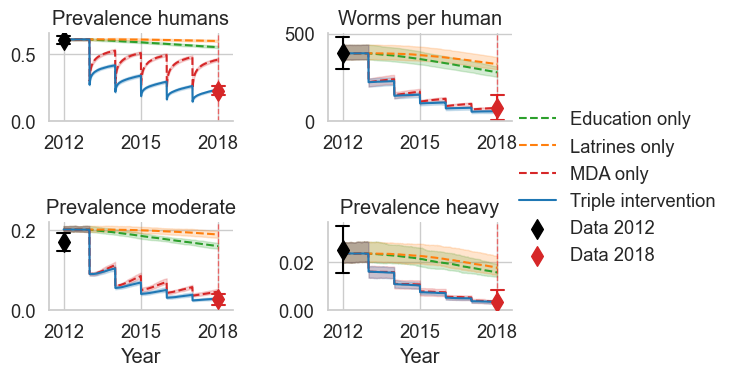

In [66]:
vars_choice = ['Prevalence humans', 'Worms per human', 'Prevalence moderate', 'Prevalence heavy']
g = sns.FacetGrid(df_ts_ABM_opt_long[df_ts_ABM_opt_long.variable.isin(vars_choice)], col='variable', 
                  col_wrap=2, sharex=False, sharey=False, height=2, aspect=1.5)
ci_line_width = .5

df_plot_full = df_ts_ABM_opt_long[df_ts_ABM_opt_long.t<=2018]


df_plot_full = df_plot_full[df_plot_full['Source'].isin(plotted_models_pred)] 

# for ax, var in zip(g.axes, df_ts_coverage.variable.unique()):
for ax, var in zip(g.axes, vars_choice):
    
    # Plot simulation runs
    df_plot = df_plot_full[df_plot_full.variable == var]
    for i, source in enumerate(df_plot.Source.unique()):
        df_line = df_plot[df_plot.Source==source]
        df_line = df_line.sort_values(['t'])

        model_style = model_styles_pred[source]
        model_color = model_colors_pred[source]
        model_label = model_labels_pred[source]

        sns.lineplot(data=df_line, x='t', y='value', errorbar=("pi", 100), ls=model_style, 
                     ax=ax, label=model_label, color=model_color)
    # Plot data, if available
    try:
        # Plot CI at start
        mu = data12.loc[data12['variable_name']==var, 'value'].item()
        sigma = data12.loc[data12['variable_name']==var, 'sem'].item()
        
        left = 2012 + ci_line_width/2
        right = 2012 - ci_line_width/2
        lower = mu - 1.96*sigma
        upper = mu + 1.96*sigma
        
        ax.plot([left, right], [upper]*2, c='k')
        ax.plot([left, right], [lower]*2, c='k')
        ax.scatter(2012, mu, c='k', zorder=10, marker='d', s=100, label='Data 2012')
        ax.plot([2012, 2012], [lower, upper], c='k')
        
        mu = data18.loc[data18['variable_name']==var, 'value'].item()
        sigma = data18.loc[data18['variable_name']==var, 'sem'].item()
        left = 2018 + ci_line_width/2
        right = 2018 - ci_line_width/2
        lower = mu - 1.96*sigma
        upper = mu + 1.96*sigma
        
        ax.plot([left, right], [upper]*2, c='tab:red')
        ax.plot([left, right], [lower]*2, c='tab:red')
        ax.scatter(2018, mu, c='tab:red', zorder=10, marker='d', s=100, label='Data 2018')
        ax.plot([2018, 2018], [lower, upper], c='tab:red')
    except:
        pass
g.set(ylim=(0, None), xticks=[2012, 2015, 2018])
g.map(plt.axvline, x=2012+years_warmup2+5, color='r', linestyle='--', linewidth=1, alpha=.5)
g.set(ylim=(0, None))
g.set_titles('{col_name}')
g.set_axis_labels('Year', '')
g.set(ylim=(0, None))

g.add_legend()
# plt.tight_layout()
plt.savefig(f'plots/model_runs_SA{no_an_str}.pdf', bbox_inches="tight")
plt.savefig(f'plots/model_runs_SA{no_an_str}.tiff', bbox_inches="tight")

#### 7b: Time series over 5 years with fitted systematic adherence¶

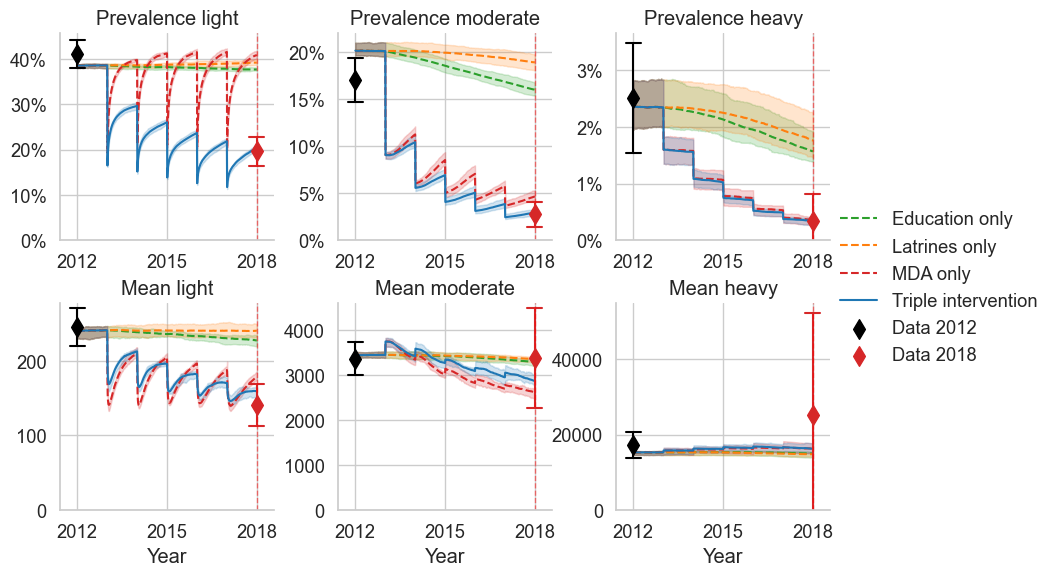

In [72]:
choice = 'means'
choice = 'distr'

df_plot_full = df_ts_ABM_opt_long[df_ts_ABM_opt_long.t<=2018]

df_plot_full = df_plot_full[df_plot_full['Source'].isin(plotted_models_pred)] 

if choice == 'means':
    vars_choice = ['Prevalence humans', 'Worms per human', 'Worms per dog',
           'Worms per cat', 'Prevalence snails', 'Prevalence fish',]
else:
    vars_choice = ['Prevalence light', 'Prevalence moderate', 'Prevalence heavy',
           'Mean light', 'Mean moderate', 'Mean heavy']

g = sns.FacetGrid(df_plot_full[df_plot_full.variable.isin(vars_choice)], col='variable', col_wrap=3, sharex=False, sharey=False, height=3)
ci_line_width = .5

for ax, var in zip(g.axes, vars_choice):
    df_plot = df_plot_full[df_plot_full.variable == var]
    df_plot = df_plot.sort_values('Source') 
    for i, source in enumerate(df_plot.Source.unique()):
        df_line = df_plot[df_plot.Source==source]
        df_line = df_line.sort_values(['t'])
        sns.lineplot(data=df_line, x='t', y='value', errorbar=("pi", 100), ls=model_styles_pred[source], ax=ax, color=model_colors_pred[source], label=model_labels_pred[source])
    if variable_percentage[var]:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    try:        
        # Plot CI at start
        mu = data12.loc[data12['variable_name']==var, 'value'].item()
        sigma = data12.loc[data12['variable_name']==var, 'sem'].item()
        
        left = 2012 + ci_line_width/2
        right = 2012 - ci_line_width/2
        lower = mu - 1.96*sigma
        upper = mu + 1.96*sigma
        
        ax.plot([left, right], [upper]*2, c='k')
        ax.plot([left, right], [lower]*2, c='k')
        ax.scatter(2012, mu, c='k', zorder=10, marker='d', s=100, label='Data 2012')
        ax.plot([2012, 2012], [lower, upper], c='k')
        
        # Plot CI at end
        mu = data18.loc[data18['variable_name']==var, 'value'].item()
        sigma = data18.loc[data18['variable_name']==var, 'sem'].item()
        left = 2018 + ci_line_width/2
        right = 2018 - ci_line_width/2
        lower = mu - 1.96*sigma
        upper = mu + 1.96*sigma
        
        ax.plot([left, right], [upper]*2, c='tab:red')
        ax.plot([left, right], [lower]*2, c='tab:red')
        ax.scatter(2018, mu, c='tab:red', zorder=10, marker='d', s=100, label='Data 2018')
        ax.plot([2018, 2018], [lower, upper], c='tab:red')
    except:
        pass

g.map(plt.axvline, x=2018, color='r', linestyle='--', linewidth=1, alpha=.5)
g.set(ylim=(0, None), xticks=[2012, 2015, 2018])
g.set_titles('{col_name}')
g.set_axis_labels('Year', '')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
g.add_legend()
plt.savefig(f'plots/model_runs_SA_full_{choice}{no_an_str}.pdf', bbox_inches="tight")
plt.savefig(f'plots/model_runs_SA_full_{choice}{no_an_str}.tiff', bbox_inches="tight")

### Time to meet public health goals

#### Heavy prevalence <1/10000

In [68]:
dfmeet = df_ts_ABM_opt_long[(df_ts_ABM_opt_long.variable=='Prevalence heavy') & (df_ts_ABM_opt_long['value']<1/10000)]
dfmeet = dfmeet.loc[dfmeet.groupby(['Source', 'seed', 'MDA_betahf_corr']).t.idxmin()]
dfmeet[['Source', 'MDA_betahf_corr', 't']].groupby(['Source', 'MDA_betahf_corr']).mean().reset_index()

,Source,MDA_betahf_corr,t
0,Education only nonsystematic,-0.9,2029.305000
1,Education only systematic,-0.9,2038.310000
2,Latrines only nonsystematic,-0.9,2040.184167
3,MDA only nonsystematic,-0.9,2016.678333
4,MDA only systematic,-0.9,2027.682500
5,Triple interventions nonsystematic,-0.9,2015.953333
6,Triple interventions systematic,-0.9,2028.678333


In [69]:
dfmeet[['Source', 'MDA_betahf_corr', 't']].groupby(['Source', 'MDA_betahf_corr']).sem().reset_index()

,Source,MDA_betahf_corr,t
0,Education only nonsystematic,-0.9,0.527663
1,Education only systematic,-0.9,0.717238
2,Latrines only nonsystematic,-0.9,1.230839
3,MDA only nonsystematic,-0.9,0.149108
4,MDA only systematic,-0.9,0.576556
5,Triple interventions nonsystematic,-0.9,0.217875
6,Triple interventions systematic,-0.9,1.107619


#### Prevalence <1/100

In [70]:
dfmeet = df_ts_ABM_opt_long[(df_ts_ABM_opt_long.variable=='Prevalence humans') & (df_ts_ABM_opt_long['value']<1/100)]
# dfmeet.loc[dfmeet.groupby(['Source']).t.idxmin()]
dfmeet = dfmeet.loc[dfmeet.groupby(['Source', 'seed', 'MDA_betahf_corr']).t.idxmin()]
dfmeet[['Source', 't', 'MDA_betahf_corr']].groupby(['Source', 'MDA_betahf_corr']).mean().reset_index()

,Source,MDA_betahf_corr,t
0,Education only nonsystematic,-0.9,2081.073333
1,MDA only nonsystematic,-0.9,2052.608333
2,MDA only systematic,-0.9,2065.708333
3,Triple interventions nonsystematic,-0.9,2028.008333
4,Triple interventions systematic,-0.9,2054.008333


In [71]:
dfmeet[['Source', 't', 'MDA_betahf_corr']].groupby(['Source', 'MDA_betahf_corr']).sem().reset_index()

,Source,MDA_betahf_corr,t
0,Education only nonsystematic,-0.9,0.393927
1,MDA only nonsystematic,-0.9,1.156623
2,MDA only systematic,-0.9,1.570916
3,Triple interventions nonsystematic,-0.9,0.149071
4,Triple interventions systematic,-0.9,0.714920
